Episode 1: Total Reward: -162.53 Timesteps: 156
Episode 2: Total Reward: -120.67 Timesteps: 154
Episode 3: Total Reward: -469.07 Timesteps: 166
Episode 4: Total Reward: -337.88 Timesteps: 288
Episode 5: Total Reward: -214.53 Timesteps: 192
Episode 6: Total Reward: -279.39 Timesteps: 160
Episode 7: Total Reward: -69.84 Timesteps: 146
Episode 8: Total Reward: -93.67 Timesteps: 222
Episode 9: Total Reward: -249.71 Timesteps: 132
Episode 10: Total Reward: -597.36 Timesteps: 210
Episode 11: Total Reward: -140.07 Timesteps: 216
Episode 12: Total Reward: -276.75 Timesteps: 138
Episode 13: Total Reward: -128.73 Timesteps: 124
Episode 14: Total Reward: -96.55 Timesteps: 140
Episode 15: Total Reward: -387.66 Timesteps: 204
Episode 16: Total Reward: -540.14 Timesteps: 208
Episode 17: Total Reward: -171.79 Timesteps: 202
Episode 18: Total Reward: -356.00 Timesteps: 260
Episode 19: Total Reward: -335.01 Timesteps: 142
Episode 20: Total Reward: -263.21 Timesteps: 154
Episode 21: Total Reward: -90.34

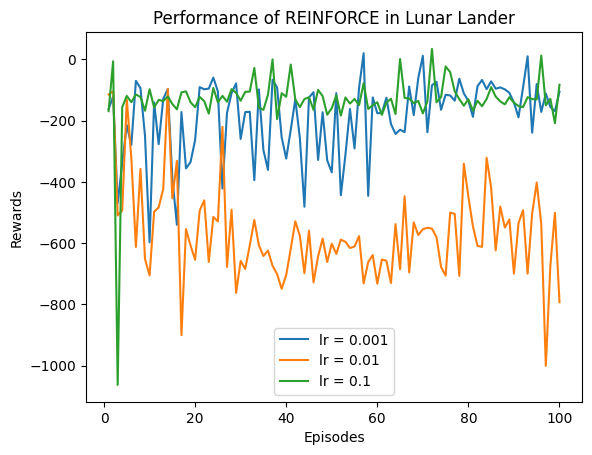

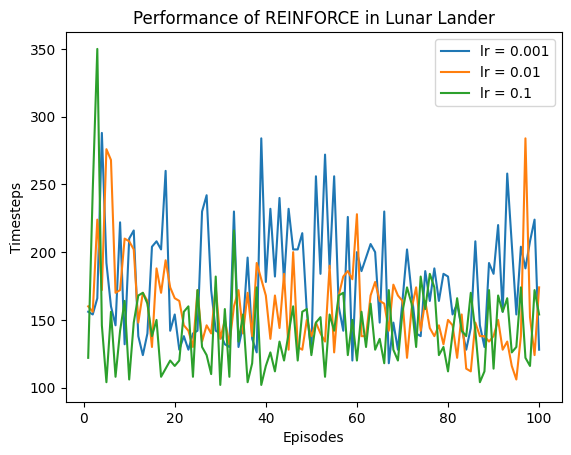

In [92]:
import gym
import numpy as np
import torch
import random
import math
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

# Define a simple policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, gamma=0.99, lr=0.001):
        super(PolicyNetwork, self).__init__()
        self.lr = lr
        self.gamma = gamma
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, output_dim)
        self.optimizer = optim.Adam(self.parameters(),lr=self.lr)

    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = self.l2(x)
        return torch.softmax(x, dim=-1)

# Function to collect trajectories
def collect_trajectories(policy_network, env):
    trajectories = []
    total_reward = 0
    timesteps = 0
    episode = {'states': [], 'actions': [], 'rewards': []}
    state = env.reset()
    done = False
    while not done:
      timesteps += 1
      state = torch.tensor(state, dtype=torch.float32)
      action_probs = policy_network(state)
      action_dist = Categorical(action_probs)
      action = action_dist.sample()
      next_state, reward, done, _ = env.step(action.item())
      total_reward += reward
      timesteps += 1
      episode['states'].append(state)
      episode['actions'].append(action)
      episode['rewards'].append(reward)
      state = next_state
    #print("Reward: {}".format(total_reward))

    trajectories.append(episode)
    return trajectories, total_reward, timesteps  #returns total reward and timesteps per episode

# Function to compute discounted rewards
def compute_discounted_rewards(rewards, gamma):
    discounted_rewards = []
    running_add = 0
    for r in reversed(rewards):
        running_add = running_add * gamma + r
        discounted_rewards.insert(0, running_add)
    return discounted_rewards

# Function to update the policy network
def update_with_baseline(policy_network, trajectories, gamma):
    for episode in trajectories:
        loss = 0
        discounted_rewards = compute_discounted_rewards(episode['rewards'], gamma)
        baseline = np.mean(discounted_rewards)
        for state, action, dr in zip(episode['states'], episode['actions'], discounted_rewards):
            action_probs = policy_network(state)
            action_dist = Categorical(action_probs)
            log_prob = action_dist.log_prob(action)
            advantage = dr - baseline
            loss -= log_prob * advantage

            #loss -= log_prob * dr
        #total_loss = loss / len(trajectories)
        policy_network.optimizer.zero_grad()
        loss.backward()
        policy_network.optimizer.step()

def update_without_baseline(policy_network, trajectories, gamma):
    for episode in trajectories:
        loss = 0
        discounted_rewards = compute_discounted_rewards(episode['rewards'], gamma)
        #baseline = np.mean(discounted_rewards)
        for state, action, dr in zip(episode['states'], episode['actions'], discounted_rewards):
            action_probs = policy_network(state)
            action_dist = Categorical(action_probs)
            log_prob = action_dist.log_prob(action)
            #advantage = dr - baseline
            loss -= log_prob * dr

            #loss -= log_prob * dr
        #total_loss = loss / len(trajectories)
        policy_network.optimizer.zero_grad()
        loss.backward()
        policy_network.optimizer.step()

# Main function for training
def train():
    # Set up environment
    random.seed(350)
    env = gym.make('LunarLander-v2')
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    hidden_dim = 256


    # Hyperparameters
    n_episodes = 100
    episode_array = [i for i in range(1,n_episodes+1)]
    gamma = 0.99

    policy_network_1 = PolicyNetwork(input_dim, hidden_dim, output_dim, lr=0.001)
    rewards_array_1 = []
    timesteps_1 = []
    #batch_size = 20
    #print("{}".format(math.floor(n_episodes/batch_size)))

    # Training loop
    for episode in range(n_episodes):
        #print("episode: {}".format((episode+1) * (n_episodes/batch_size) ))
        trajectories, rewards, timesteps = collect_trajectories(policy_network_1, env)
        update_without_baseline(policy_network_1, trajectories, gamma)
        timesteps_1.append(timesteps)
        rewards_array_1.append(rewards)
        #trajectories_1.extend(trajectories)

        print("Episode {}: Total Reward: {:.2f} Timesteps: {}".format(episode + 1, rewards, timesteps))



    policy_network_2 = PolicyNetwork(input_dim, hidden_dim, output_dim, lr=0.01)
    rewards_array_2 = []
    timesteps_2 = []

    for episode in range(n_episodes):
        #print("episode: {}".format((episode+1) * (n_episodes/batch_size) ))
        trajectories, rewards, timesteps = collect_trajectories(policy_network_2, env)
        update_without_baseline(policy_network_2, trajectories, gamma)
        timesteps_2.append(timesteps)
        rewards_array_2.append(rewards)
        #trajectories_1.extend(trajectories)

        print("Episode {}: Total Reward: {:.2f} Timesteps: {}".format(episode + 1, rewards, timesteps))

    policy_network_3 = PolicyNetwork(input_dim,hidden_dim, output_dim, lr=0.1)
    rewards_array_3 = []
    timesteps_3 = []

    for episode in range(n_episodes):
        #print("episode: {}".format((episode+1) * (n_episodes/batch_size) ))
        trajectories, rewards, timesteps = collect_trajectories(policy_network_3, env)
        update_without_baseline(policy_network_3, trajectories, gamma)
        timesteps_3.append(timesteps)
        rewards_array_3.append(rewards)
        #trajectories_1.extend(trajectories)

        print("Episode {}: Total Reward: {:.2f} Timesteps: {}".format(episode + 1, rewards, timesteps))




    plt.title("Performance of REINFORCE in Lunar Lander")
    plt.plot(episode_array, rewards_array_1, label = "lr = 0.001")
    plt.plot(episode_array, rewards_array_2, label = "lr = 0.01")
    plt.plot(episode_array, rewards_array_3, label = "lr = 0.1")
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.legend()
    plt.show()


    plt.title("Performance of REINFORCE in Lunar Lander")
    plt.plot(episode_array, timesteps_1, label = "lr = 0.001")
    plt.plot(episode_array, timesteps_2, label = "lr = 0.01")
    plt.plot(episode_array, timesteps_3, label = "lr = 0.1")
    plt.xlabel("Episodes")
    plt.ylabel("Timesteps")
    plt.legend()
    plt.show()






    env.close()

# Run the training
train()